<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/066_Kalman_Filter_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛰️ Filtr Kalmana: Jak namierzyć rakietę?

Mamy obiekt (np. pociąg), który porusza się w jednym wymiarze.
Mamy GPS, który mierzy jego pozycję, ale ma duży szum (błąd +/- 10 metrów).

Filtr Kalmana to algorytm, który utrzymuje dwa stany:
1.  **Stan ($x$):** Gdzie myślimy, że jesteśmy? (Pozycja, Prędkość).
2.  **Niepewność ($P$):** Jak bardzo jesteśmy tego pewni? (Macierz Kowariancji).

**Cykl życia Kalmana:**
1.  **PREDYKCJA (Fizyka):** "Skoro jechałem 50 m/s, to teraz powinienem być tu. Moja niepewność rośnie (bo dawno nie patrzyłem na czujnik)."
2.  **AKTUALIZACJA (Pomiar):** "GPS mówi, że jestem tam. Ale GPSowi ufam średnio. Uśrednię moją predykcję z GPSem, biorąc poprawkę na to, kto jest bardziej wiarygodny (**Kalman Gain**)."

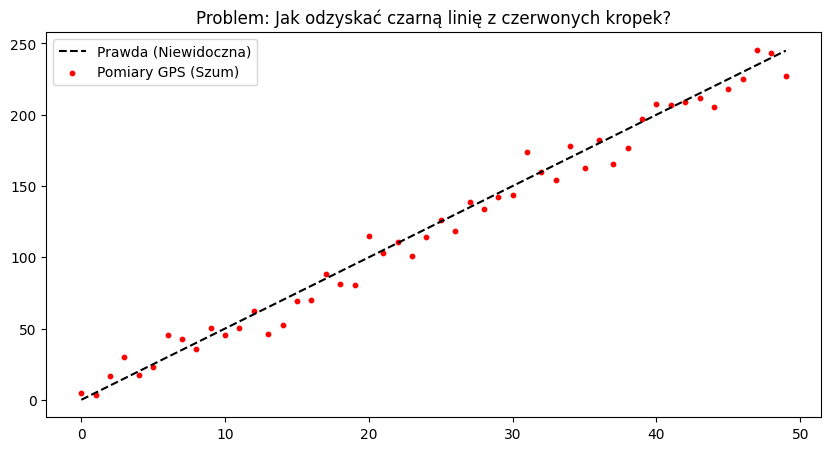

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. SYMULACJA RZECZYWISTOŚCI
# Pociąg jedzie ze stałą prędkością, ale GPS szumi.

np.random.seed(42)
n_steps = 50
dt = 1.0 # Krok czasowy (1 sekunda)

# Prawdziwy stan
true_position = np.zeros(n_steps)
true_velocity = 5.0 # 5 m/s
current_pos = 0.0

for i in range(n_steps):
    true_position[i] = current_pos
    current_pos += true_velocity * dt

# Pomiary (GPS) - dodajemy szum
gps_noise = 10.0 # Błąd GPS to +/- 10 metrów (sporo!)
measurements = true_position + np.random.normal(0, gps_noise, n_steps)

# Wizualizacja problemu
plt.figure(figsize=(10, 5))
plt.plot(true_position, label='Prawda (Niewidoczna)', linestyle='--', color='black')
plt.scatter(range(n_steps), measurements, label='Pomiary GPS (Szum)', color='red', s=10)
plt.title("Problem: Jak odzyskać czarną linię z czerwonych kropek?")
plt.legend()
plt.show()

## Matematyka Kalmana (Macierze)

Musimy zdefiniować macierze fizyki. Nasz stan to wektor 2-elementowy:
$$ x = \begin{bmatrix} \text{pozycja} \\ \text{prędkość} \end{bmatrix} $$

1.  **Macierz F (Fizyka):** Jak stan zmienia się w czasie?
    *   $Poz_{new} = Poz_{old} + Vel_{old} \cdot dt$
    *   $Vel_{new} = Vel_{old}$ (zakładamy stałą prędkość)
2.  **Macierz H (Pomiar):** Co mierzymy?
    *   Mierzymy tylko pozycję (GPS). Nie mierzymy prędkości.
3.  **Macierz R (Szum pomiaru):** Jak bardzo ufać GPSowi? (Dużo).
4.  **Macierz Q (Szum procesu):** Jak bardzo ufać fizyce? (Mało - bo pociąg może przyspieszyć).

In [2]:
class KalmanFilter:
    def __init__(self, dt, u_gps, u_physics):
        # dt: krok czasu
        # u_gps: niepewność GPS (Measurement Noise)
        # u_physics: niepewność modelu fizycznego (Process Noise)
        
        # 1. Stan początkowy [Pozycja, Prędkość]
        # Zgadujemy, że jesteśmy w 0 i stoimy w miejscu.
        self.x = np.array([[0.0], [0.0]])
        
        # 2. Macierz Niepewności (P) - Początkowo duża (nie wiemy gdzie jesteśmy)
        self.P = np.eye(2) * 1000.0
        
        # 3. Macierz Fizyki (F)
        # x = x + v*dt
        # v = v
        self.F = np.array([[1.0, dt],
                           [0.0, 1.0]])
        
        # 4. Macierz Pomiaru (H)
        # Mierzymy tylko pozycję (pierwszy element stanu)
        self.H = np.array([[1.0, 0.0]])
        
        # 5. Szumy (R i Q)
        self.R = np.array([[u_gps**2]]) # Wariancja pomiaru
        self.Q = np.eye(2) * u_physics  # Wariancja procesu

    def predict(self):
        # KROK 1: Fizyka (Przewidywanie przyszłości)
        # x = F * x
        self.x = self.F @ self.x
        
        # Niepewność rośnie! (bo minął czas, a nie patrzyliśmy na czujnik)
        # P = F * P * F^T + Q
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, z):
        # KROK 2: Korekta (Mamy nowy pomiar z)
        
        # Błąd pomiaru (Residual): Różnica między GPS a naszym przewidywaniem
        y = z - (self.H @ self.x)
        
        # Kalman Gain (K): Komu ufać? (Fizyce czy GPSowi?)
        # S = H*P*H^T + R
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        # Aktualizacja stanu
        self.x = self.x + (K @ y)
        
        # Aktualizacja niepewności (Maleje, bo mamy nowy odczyt!)
        # P = (I - K*H) * P
        I = np.eye(2)
        self.P = (I - (K @ self.H)) @ self.P
        
        return self.x

print("Klasa filtra gotowa.")

Klasa filtra gotowa.


## Uruchomienie Filtra

Puścimy nasz filtr na wygenerowanych danych.
Zauważ, że filtr na początku "nie wie" nic. Będzie musiał szybko zorientować się, że pociąg jedzie i z jaką prędkością.

In [3]:
# Inicjalizacja filtra
# Niepewność GPS = 10.0 (tak jak w danych)
# Niepewność Fizyki = 0.1 (zakładamy, że pociąg jedzie raczej stabilnie)
kf = KalmanFilter(dt=1.0, u_gps=10.0, u_physics=0.1)

kalman_estimates = []
kalman_uncertainty = []

for measure in measurements:
    # 1. Przewiduj
    kf.predict()
    
    # 2. Aktualizuj pomiarem
    # Pomiar musi być w formacie [[z]]
    estimated_state = kf.update(np.array([[measure]]))
    
    # Zapisz pozycję (pierwszy element stanu)
    kalman_estimates.append(estimated_state[0, 0])
    kalman_uncertainty.append(kf.P[0, 0]) # Zapisz niepewność pozycji

print("Filtrowanie zakończone.")

Filtrowanie zakończone.


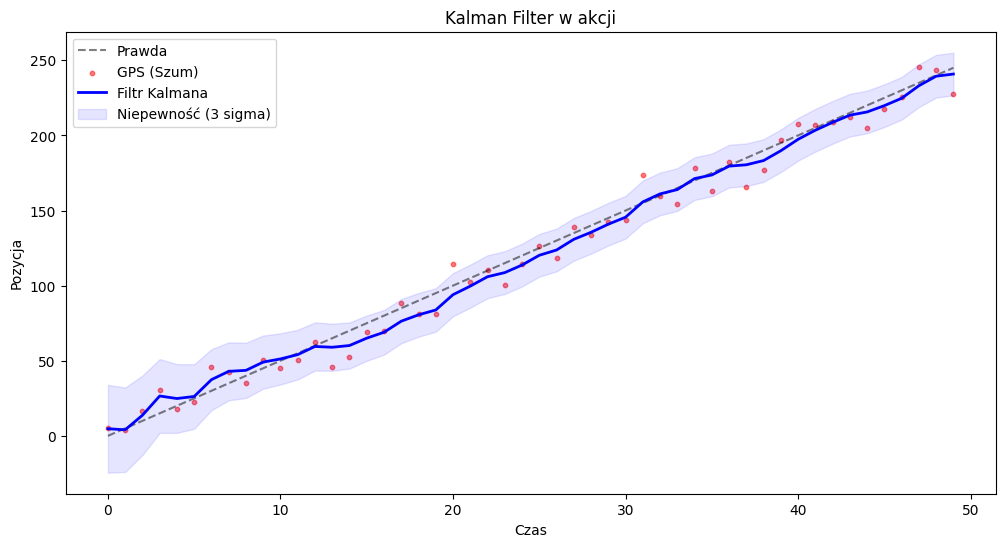

In [4]:
# WIZUALIZACJA WYNIKÓW
plt.figure(figsize=(12, 6))

plt.plot(true_position, 'k--', label='Prawda', alpha=0.5)
plt.scatter(range(n_steps), measurements, c='red', s=10, label='GPS (Szum)', alpha=0.5)
plt.plot(kalman_estimates, 'b-', linewidth=2, label='Filtr Kalmana')

# Obszar niepewności (Confidence Interval)
uncertainty = np.sqrt(kalman_uncertainty)
plt.fill_between(range(n_steps), 
                 np.array(kalman_estimates) - 3*uncertainty, 
                 np.array(kalman_estimates) + 3*uncertainty, 
                 color='blue', alpha=0.1, label='Niepewność (3 sigma)')

plt.title("Kalman Filter w akcji")
plt.xlabel("Czas")
plt.ylabel("Pozycja")
plt.legend()
plt.show()

## 🧠 Podsumowanie: Sensor Fusion

Co się stało na wykresie?
1.  **Niebieska linia (Kalman)** jest znacznie gładsza niż czerwone kropki (GPS).
2.  Kalman "odgadł" prawdziwą trasę (czarna linia), ignorując skoki GPS-u.
3.  **Bonus:** Zauważ, że choć nie mierzyliśmy prędkości, Kalman ją sobie "wyliczył" wewnątrz (jako drugi element wektora stanu), obserwując zmiany pozycji.

**Zastosowania:**
*   Auta autonomiczne (Lidar + Radar + Kamera).
*   Gry VR (pozycja głowy).
*   Giełda (wygładzanie cen akcji - choć tam działa gorzej, bo giełda nie ma pędu fizycznego).